In [44]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numba
import pandas as pd
from matplotlib.pyplot import cm
from numba import float64
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

In [45]:
@numba.njit
def check_boundaries(positions, L): 
    #return positions
    up, down= np.where(positions > L/2), np.where(-1*positions > L/2)
    positions[up] -= L
    positions[down] += L
    return positions 

rtest = np.linspace(-3,3,10)
print(rtest)
array = check_boundaries(rtest, 10)
print(array)

[-3.         -2.33333333 -1.66666667 -1.         -0.33333333  0.33333333
  1.          1.66666667  2.33333333  3.        ]
[-3.         -2.33333333 -1.66666667 -1.         -0.33333333  0.33333333
  1.          1.66666667  2.33333333  3.        ]


In [46]:
@numba.njit
def generate_fcc_positions(nx, ny, nz, rho, dtype=np.float32): ##put fcc lattices according to the density
    D=3  #D is set to 3, representing a three-dimensional space. 
    conf = np.zeros((nx*ny*nz*4, D), dtype=dtype) 
    count = 0 
    for ix in range(nx):
        for iy in range(ny):
            for iz in range(nz):
                conf[count+0,:] = [ix+0.25, iy+0.25, iz+0.25]
                conf[count+1,:] = [ix+0.75, iy+0.75, iz+0.25]
                conf[count+2,:] = [ix+0.75, iy+0.25, iz+0.75]
                conf[count+3,:] = [ix+0.25, iy+0.75, iz+0.75]
                count += 4
    for k in range(D):
        conf[:,k] -= np.mean(conf[:,k]) # put sample in the middle of the box
        
    sim_box = np.array((nx, ny, nz), dtype=dtype) #simulation box
    rho_initial = 4.0
    scale_factor = dtype((rho_initial/rho)**(1/D)) # scale both the positions (conf) and the simulation box (sim_box). 
    #This scaling ensures that the final density of the generated configuration matches the desired rho.
    
    return conf*scale_factor, sim_box*scale_factor

def generate_random_velocities(N, D, T, dtype=np.float32):
    v = dtype(np.random.normal(0.0, T**0.5, (N,D)))    ###### Assuming m=1, ######
    for k in range(D):
        v[:,k] -= np.mean(v[:,k]) # remove drift
        #So the mean of every element subtracted by the mean is zero
    return v

@numba.njit
def lj_potential(r, epsilon=1.0, sigma=1.0):
    return 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

@numba.njit
def calculate_potential_energy(R, L):
    N, D = R.shape
    energy = 0.0
    for i in range(N):
        for j in range(i + 1, N):
            rij = R[j] - R[i]
            rij = check_boundaries(rij, L)
            r = np.linalg.norm(R[i] - R[j])  # Euclidean distance between particles i and j
            energy += lj_potential(r)
    return energy
@numba.njit
def VerletNextR(r_t, v_t, a_t, h, L):
    r_t_plus_h = r_t + v_t*h + 0.5*a_t*h*h
    return r_t_plus_h
@numba.njit
def VerletNextV(v_t,a_t,a_t_plus_h,h):
    v_t_plus_h = v_t + 0.5*(a_t + a_t_plus_h)*h
    return v_t_plus_h
@numba.njit
def kinetic_energy(V, M):
    return np.sum(V**2)*M*0.5
@numba.njit
def calculate_forces(R, L):
    # N,D = R.shape 
    N = len(R)
    ####epsilon = 1e-9
    forces = np.zeros_like(R)
    for i in range(N):
        for j in range(i + 1, N):
            rij = R[j] - R[i]    ###D dimentional. vector point from i to j
            ######FIND THE SHORTEST PATH!
            rij = check_boundaries(rij, L)
            r = np.linalg.norm(rij)
            #r = np.sqrt(np.sum(rij ** 2))
            f = -48 * (1 / (r ** 14) - 0.5 / (r ** 8)) * rij 
            ##newton's 3rd law reaction-pair: conservation of energy
            forces[i] += f
            forces[j] -= f

    return forces

In [47]:
  ##tau =0.2 test periodic first and then paper, also test periodic with looping T!!!(do it in small steps so it doesnt explode)

In [48]:
### Testing!
conf, simbox = generate_fcc_positions(3, 3, 3, 1.0, dtype=np.float32)
vel = generate_random_velocities(conf.shape[0], conf.shape[1], T=1) ##if T= 0 they should be 0
conf2 = conf+ np.random.uniform(-1,+1, conf.shape)*0.1
#forces = calculate_forces(conf2, 3)  
nrg = calculate_potential_energy(conf2, simbox[0])
#print(vel)
print(conf[:5,:])
print(simbox)
#print(forces[0,:])
print(nrg)


In [ ]:
@numba.njit
def nhchain(dt, R, V, A, L, m, friction, Q, N,T, step, Pos_history):
    Rnh = R + V*dt+ (1/2)*(A -friction*V)*dt*dt
    for xi in range(N):
            Rnh[xi] = check_boundaries(Rnh[xi], L)
    K = kinetic_energy(V, m)
    halfVnh = V + (1/2)*(A -friction*V)*dt
    Fnh = calculate_forces(Rnh, L)
    Anh = Fnh/m
    halfKnh = kinetic_energy(halfVnh, m)
    halffriction_nh = friction + (1/2)*(  K - (3/2)*(N+1)*T  )*(dt/Q)
    friction_nh = halffriction_nh + (1/2)*( halfKnh - (3/2)*(N+1)*T )*(dt/Q)
    Vnh = (halfVnh + (dt/2)*(  Fnh/m ) )/( 1+  (dt/2)*(  friction_nh ))
    Knh = kinetic_energy(Vnh, m)
    Pos_history[step] = Rnh.reshape(3,-1).T
    return Rnh, Vnh, friction_nh

###calculate Cv on graph E vsT and as variance to test it!!!!canonical ensemble

In [ ]:
def Verlet(h, R, V, A, L, M, K, E, N,step, Pos_history):
    for xi in range(N):
            R[xi] = check_boundaries(R[xi], L)
        
    newR = VerletNextR(R, V, A, h, L)
    Pos_history[step] = newR.reshape(3,-1).T
    F = calculate_forces(R, L)
    A = F/M
    newF = calculate_forces(newR, L)## calculate forces with new positions newR
    newA = newF/M
    newV = VerletNextV(V, A, newA, h)
        
    return newR, newV

In [ ]:
#calculate_forces(conf+ np.random.uniform(-1,+1, conf.shape)*0.1)  
###"mostly should kinda be 0 but some particles are missing neighbours and we do not have an infinite sample"
##"the nearest neighbours should be 0 but then you have neighbours further away and in an infinite sample they should cancel out"

In [ ]:
#@numba.njit
#@numba.njit(nopython=True)
def simulate(Ncube, T0, M, steps, h):
    #N = Ncube**3
    R, simbox = generate_fcc_positions(Ncube, Ncube, Ncube, 1.0, dtype=np.float32)
    N,D = R.shape
    L = simbox[0]
    V = generate_random_velocities(len(R), 3, T0, dtype=np.float32)
    A = np.zeros((len(R),3))
    
    K = np.zeros(steps)
    E = np.zeros(steps)
    Pos_history = np.zeros((steps, len(R), 3), dtype=np.float32)  
    distance = np.zeros(steps)
    
    friction = 0  
    Q = 1

    for t in range(0, steps): 
        newR, newV, newfriction =nhchain(h, R, V, A, L, M, friction, Q, N, T0, t, Pos_history)
        #newR, newV = Verlet(h, R, V, A, L, M, K, E, N,t, Pos_history)
        K[t] = kinetic_energy(newV, M)
        E[t]   = calculate_potential_energy(newR, L)

        R, V, friction = newR, newV, newfriction

    return E, distance, V, Pos_history, K

In [ ]:
M = 1.0

Ncube = 3
N = Ncube**3
steps = 10000
h= 0.0005

In [ ]:

###change it to != cube (we assume that Lx =Ly= Lz, so change so that they can be different)
T0= 1 
Es, distances, V, Pos_history, K = simulate(Ncube, T0, M, steps, h)

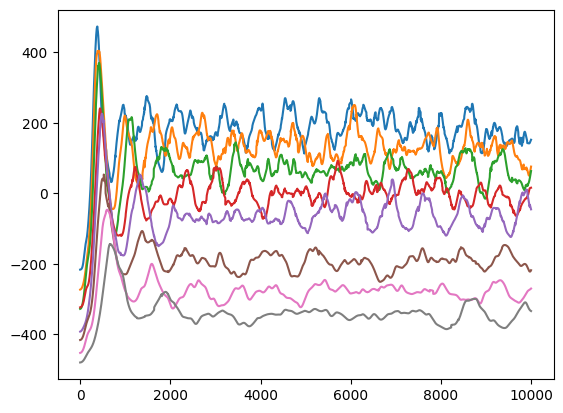

In [ ]:
####make scan over temperatures:(start with the biggest, save only the last iterations to account for relaxation time)
Temps = np.arange(2.0, 0.2, -0.1)
Es_history_T = np.zeros((steps, len(Temps)), dtype=np.float32) 
for i, Temp in enumerate(Temps):
    Es_T, distances_T, V_T, Pos_history_T, K_T = simulate(Ncube, Temp, M, steps, h)
    plt.plot(np.arange(0, steps, 1, dtype=int), Es_T + K_T) #####Wrong plot. Should be written Es_T and K_T
    Es_history_T[:, i] = Es_T

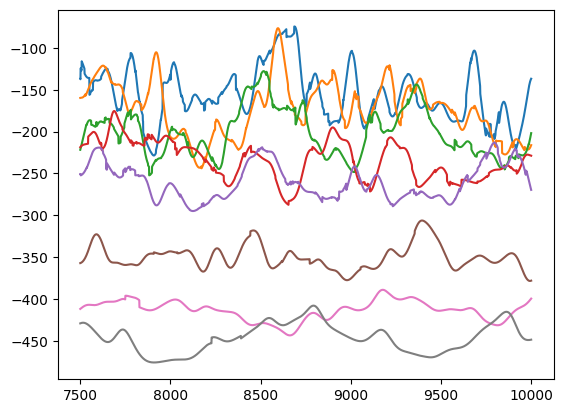

In [ ]:
upperbond= steps
downwardbond= int((3/4)*steps)
for i in range(len(Temps)):
    plt.plot(np.arange( downwardbond, upperbond, 1, dtype=int), Es_history_T[downwardbond:upperbond, i])

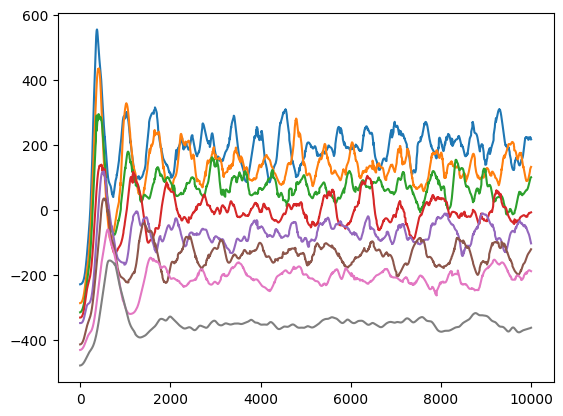

In [ ]:
Es_history_e = np.zeros((steps, len(Temps)), dtype=np.float32) 
Es_final = np.zeros(len(Temps), dtype=np.float32) 
for i, Temp in enumerate(Temps):
    Es_e, distances__e, V_e, Pos_history_e, K_e = simulate(Ncube, Temp, M, steps, h)
    plt.plot(np.arange(0, steps, 1, dtype=int), Es_e + K_e)
    Es_history_e[:, i] = Es_e
    Es_final[i] = Es_e[steps-1]

10000 10000
[-108.47769 -159.6307  -165.92612 -247.1652  -279.5187  -311.78348
 -319.48044 -464.08167]


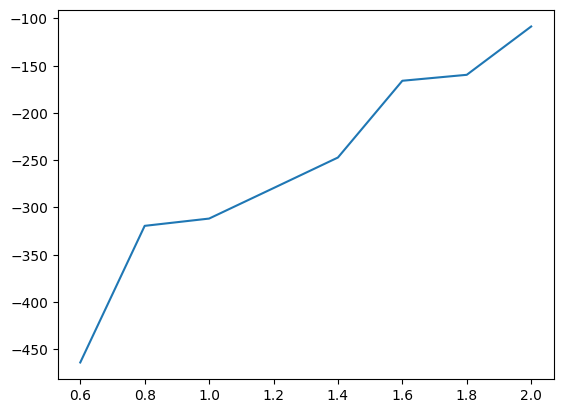

In [ ]:
K
print(len(K), len(Es))
print(Es_final)
plt.plot(Temps, Es_final)
Es_mean = np.zeros(len(Temps), dtype=np.float32) 
Cv_var = np.zeros(len(Temps), dtype=np.float32) 
for i in range(len(Temps)):
    Es_mean[i] = np.mean(Es_history_e[int(0.8*steps):steps, i])
    Cv_var[i] = (np.var(Es_history_e[int(0.8*steps):steps, i]) )/ (Temps[i]**2)


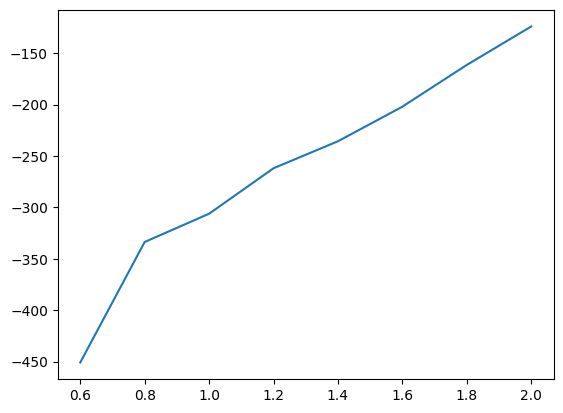

In [ ]:
plt.plot(Temps, Es_mean)

(8,)


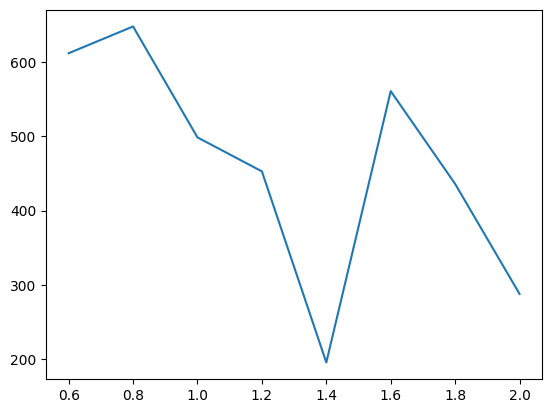

In [ ]:
print(Cv_var.shape)
plt.plot(Temps,Cv_var)

In [ ]:
print(simbox)
#### time stuff!
#print(Es_history_e[:, len(Temps)-1])
print(Es_history_e.shape)

[4.762203 4.762203 4.762203]
(10000, 8)


10000 10000


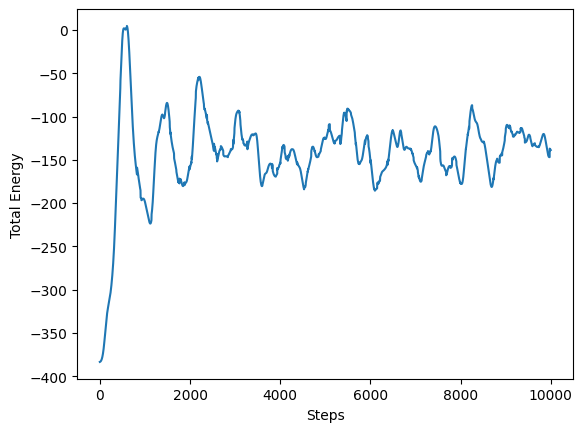

In [ ]:
TotalE = K + Es
print(len(K), len(Es))
plt.plot(np.arange(0, steps, 1, dtype=int),TotalE)
plt.xlabel("Steps")
plt.ylabel("Total Energy")
#plt.ylim(-560, -580)
VarE = np.var(TotalE) ###get the variance in a numpy array (maybe in relation to the average!!!)

In [ ]:
###try to make variance through calculating the mean energy and using the formula
''' Cv_gradient[:,d] = np.gradient(E_mean[:,d],T)
        for i in range(len(T)):
            Cv_variance[i,d] = E_var[i,d]/T[i]**2'''

' Cv_gradient[:,d] = np.gradient(E_mean[:,d],T)\n        for i in range(len(T)):\n            Cv_variance[i,d] = E_var[i,d]/T[i]**2'

10000 108


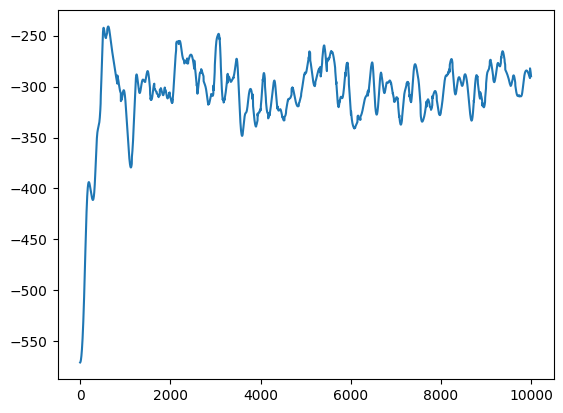

In [ ]:
plt.plot(Es)
#plt.ylim(0,1000)
#plt.xlim(1,1.19)
print(len(distances), len(V))

4.762203


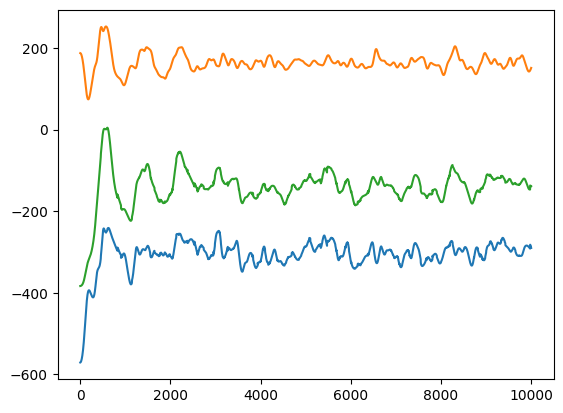

In [ ]:

###plot of energies
plt.plot(Es)
plt.plot(K)
plt.plot(K+Es)
#print(type(K))
#print(K+Es)
print(simbox[0])
#plt.ylim(-1250,-900)

In [ ]:
Es

array([-570.83161695, -570.80710899, -570.76750512, ..., -289.01340347,
       -289.44563923, -289.88772976])

In [ ]:
####Changed simulation
def simulateT(T0, M, steps, h, R, simbox, V, A, K, E, Pos_history, distance):
    N,D = R.shape
    L = simbox[0]
    
    friction = 0  
    Q = 1

    for t in range(0, steps): 
        # Update T0 every 500 steps
        if t % 500 == 0:
            T0_index = t // 500 % len(T0)
            T = T0[T0_index]
            
        newR, newV, newfriction =nhchain(h, R, V, A, L, M, friction, Q, N, T, t, Pos_history)
        #newR, newV = Verlet(h, R, V, A, L, M, K, E, N,t, Pos_history)
        K[t] = kinetic_energy(newV, M)
        E[t]   = calculate_potential_energy(newR, L)

        R, V, friction = newR, newV, newfriction

    return E, distance, V, Pos_history, K

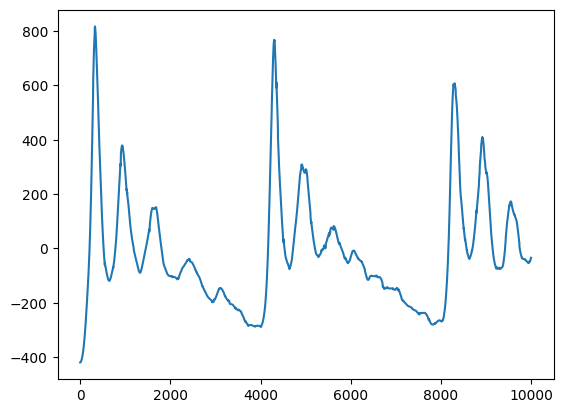

In [ ]:
####TO BE CHANGED!


R_R, simbox = generate_fcc_positions(Ncube, Ncube, Ncube, 1.0, dtype=np.float32)
V_R = generate_random_velocities(len(R_R), 3, T0, dtype=np.float32)
A_R = np.zeros((len(R_R),3))
K_R = np.zeros(steps)
E_R = np.zeros(steps)
Pos_history_R = np.zeros((steps, len(R_R), 3), dtype=np.float32) 
distances_R = np.zeros(steps) 

Temps = np.arange(2.0, 0.5, -0.2)
Es_history_R = np.zeros((steps, len(Temps)), dtype=np.float32) 
#####CHANGE BELLOW!!!
#for i, Temp in enumerate(Temps):
Es_R, distances_R, V_R, Pos_history_R, K_R =simulateT(Temps, M, steps, h, R_R, simbox, V_R, A_R, K_R, E_R, Pos_history_R, distances_R)
plt.plot(np.arange(0, steps, 1, dtype=int), E_R + K_R)
#Es_history_R[:, i] = Es_R
###review the graph

In [ ]:
####MAKE HEAT CAPACITY, MAKE RELATION, change like every 200 steps
print(Es_history_R.shape)
E_means = np.zeros(len(Temps))
for i in range(len(Temps)):
    E_means[i] = np.mean(Es_history_R[:, i])
print(E_means)

(10000, 8)
[0. 0. 0. 0. 0. 0. 0. 0.]


C:\Users\35196\AppData\Local\Temp\ipykernel_24888\3942138468.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, s=100, c=c) #, alpha = t/steps


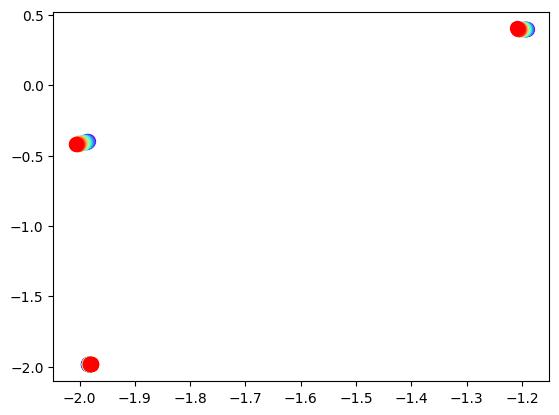

10000

In [ ]:
###see particles
n_colours = 30
colour = iter(cm.rainbow(np.linspace(0, 1, n_colours)))
for t in range(0,n_colours): ##number of steps
    c = next(colour)
    for i in range(4): ###number of particles
        x = Pos_history[t][i][0]  # x-coordinate
        y = Pos_history[t][i][1]  # y-coordinate   
        #plt.scatter(x, y, s=100,c ='green', alpha = t/steps)  # Plot point with specified size and color
        plt.scatter(x, y, s=100, c=c) #, alpha = t/steps
plt.show()
len(Pos_history)

In [ ]:
####TIME FOR SOME ANIMATIONS!!!!!!!!

Improvements:

1. Test if we are in the canonical ensemble: graph E vs T and calculate Cv
2. Implement the cycle with relaxation period where I change the temperature in the middle of the cycle
3. Make 3D graphs and animations
4. Change the code to allow for different crystalline structures
5. Do a lot of optimization to ensure faster code
6. Try catch error to prevent unwanted situations
7. Test it for different values of Q(be careful because some values will give me wrong results), friction, sigma and epsilon
8. Run the code for way more iterations
9. Created a file to save and analyse the data
10. Suggestions?